In [1]:
class AutoRangingDetector(object):
    def __init__(self, panels, rows, cols, cameraType=None, cameraConfig=None):
        self.panels = panels
        self.rows = rows
        self.cols = cols
        self.cameraType = cameraType
        self.cameraConfig = cameraConfig

        cameraTypes = ["JF", "ePix10k", "ePix10kTender"]
        if self.cameraType not in cameraTypes:
            print "'%s' not in recognized cameras" %(cameraType), cameraTypes
            raise
        cameraConfigs = [None, 
                         "highLow", "mediumLow", ## autoranging ePix10k
                         "fixedHigh", "fixedMedium", "fixedLow"] ## fixed
        if cameraConfig not in cameraConfigs:
            print "'%s' not in recognized camera configs" %(cameraConfig), cameraConfigs
            raise
        if self.cameraType == "JF":
            self.nBits = 14
            self.maxEnergy = 15000*8 ##keV
            self.nRanges = 3
            self.switchPoints = [40*8, 1500*8, self.maxEnergy*666] ## keV
            self.switchPointVariations = [1.*8, 10.*8, 0.] ## keV, placeholder
            self.switchPointWidths = [1.*8, 10.*8, 0.] ## keV, placeholder
            self.offsets = [0, 2100, 1900] ## ADU; placeholder
            self.gains = [40., 1., 0.1] ## ADU/keV
            self.gainErrors = [0.01, 0.015, 0.02] ## dimensionless, placeholder
            self.nonLinearity = [0.01/320, 0.015/12000, 0.017/self.maxEnergy] ## 1/keV, placeholder
        elif 'ePix10k' in self.cameraType:
            self.nBits = 14
            self.maxEnergy = 10000*8 ##keV
            self.nRanges = 2
            if self.cameraConfig in ["mediumLow", "fixedMedium", "fixedLow"]:
                self.switchPoints = [300*8, self.maxEnergy*666] ## keV
                if self.cameraConfig == "fixedMedium":
                    tmp = self.switchPoints[0]
                    self.switchPoints[0] = self.maxEnergy*666
                    self.maxEnergy = tmp
                if self.cameraConfig == "fixedLow":
                    self.switchPoints[0] = -666
                self.switchPointVariations = [4.*8, 0.] ## keV, placeholder
                self.switchPointWidths = [4.*8, 0.] ## keV, placeholder
                self.offsets = [0, 2100] ## ADU; placeholder
                self.gains = [4.1, 0.01] ## ADU/keV
                self.gainErrors = [0.01, 0.015] ## dimensionless, placeholder
                self.nonLinearity = [0.01/2400, 0.017/self.maxEnergy] ## 1/keV, placeholder
            else:
                self.switchPoints = [100*8, self.maxEnergy*666] ## keV
                if self.cameraConfig == "fixedHigh":
                    tmp = self.switchPoints[0]
                    self.switchPoints[0] = self.maxEnergy*666
                    self.maxEnergy = tmp
                self.switchPointVariations = [2.*8, 0.] ## keV, placeholder
                self.switchPointWidths = [2.*8, 0.] ## keV, placeholder
                self.offsets = [0, 1100] ## ADU; placeholder
                self.gains = [12.5, 0.1] ## ADU/keV
                self.gainErrors = [0.01, 0.015] ## dimensionless, placeholder
                self.nonLinearity = [0.01/800, 0.017/self.maxEnergy] ## 1/keV, placeholder
        else:
            print self.cameraType, cameraTypes
            raise Exception

        self.minE = [0.] + self.switchPoints[0:self.nRanges-1] ## keV
        ## this is for adding nonlinearity
        ## calculated with respect to start of range
        self.nonLinearity = np.array(self.nonLinearity)
        #self.nonLinearity *= 0. ## comment out to get nonlinearity

        self.setupMatrices()
        ## the idea is to allow us to use a scalar to describe the 2d array
        ## corresponding to a particular characteristic
        ## or to smear a 2d array
        ## or one might use a numpy array to set the 2d array

    def updateFlatGains(self, flatGains):  ## not sure this makes sense in the residual world
        self.gains = self.matricize(flatGains)
        raise Exception

    def updateFlatOffsets(self, flatOffsets):
        self.offsets = self.matricize(flatOffsets)

    def updateFlatSwitchPoints(self, flatSwitchPoints):
        self.switchPoints = self.matricize(flatSwitchPoints)

    def updateSwitchPoints(self, switchPoints):
        self.switchPoints = switchPoints

    def setupMatrices(self):
        self.residualGains = self.matricize(self.gains, self.gainErrors, None)/self.matricize(self.gains, None, None)
        self.offsets = self.matricize(self.offsets)
        self.switchPoints = self.matricize(self.switchPoints, None, self.switchPointVariations)

    def matricize(self, array, relativeSmear=None, absoluteSmear=None):
        base = np.ones((self.panels, self.rows, self.cols))
        tmp = []
        [tmp.append(array[i]*base) for i in range(self.nRanges)]
        if relativeSmear is not None: ## should probably be by range, handle array or scalar
            if not np.isscalar(relativeSmear):
                print "temp check in relativeSmear array handler"
                if len(relativeSmear)==self.nRanges:
                    for n in range(self.nRanges): ## lazy and unidiomatic
                        smears = 1 + (np.random.normal(size=self.panels*self.rows*self.cols).reshape((self.panels, self.rows, self.cols))).clip(-3,3)*relativeSmear[n]
                        ## clip to eliminate unfortunate tails, e.g. negative gain 
                        tmp[n] *= smears
                else:
                    raise Exception
            else:
                smears = 1 + np.random.normal(size=self.nRanges*self.panels*self.rows*self.cols).reshape((nRanges, self.panels, self.rows, self.cols))*relativeSmear
                tmp += smears 
        if absoluteSmear is not None: ## should probably be by range, handle array or scalar
            if not np.isscalar(absoluteSmear):
                print "temp check in absoluteSmear array handler"
                if len(absoluteSmear)==self.nRanges:
                    for n in range(self.nRanges): ## lazy and unidiomatic
                        smears = (np.random.random(self.panels*self.rows*self.cols).reshape((self.panels, self.rows, self.cols))-0.5)*absoluteSmear[n] ## shifts 0, 1 to -0.5, 0.5 and scales
                        tmp[n] += smears
                else:
                    raise Exception
            else:
                smears = (np.random.random(self.nRanges*self.panels*self.rows*self.cols).reshape((nRanges, self.panels, self.rows, self.cols))-0.5)*absoluteSmear ## shifts 0, 1 to -0.5, 0.5 and scales
                tmp += smears
        return np.array(tmp)

    def setGains(self, gains):
        if gains.shape != (self.nRanges, self.panels, self.rows, self.cols):
            print "gain problem,", gains.shape, "!=", (self.panels, self.rows, self.cols)
            raise
        self.gains = gains

    def setOffsets(self, offsets):
        print "foo", 1/0

In [2]:
class BuildAutoRangeFrames(object):
    def __init__(self, detector, I0width, I0min=0, I0max=300000, flatField=None):
        self.det = detector
        self.panels = self.det.panels
        self.rows = self.det.rows
        self.cols = self.det.cols
        self.frame = np.zeros((self.panels, self.rows, self.cols))
        self.gainBits = np.zeros((self.panels, self.rows, self.cols), dtype=int)
        
        self.I0max = I0max
        self.I0min = I0min
        self.I0saturated = 250000
        self.I0width = I0width

        self.flatField = flatField

        self.twoTo14 = 2**14

    def getTrueI0(self):
        self.trueI0 = np.random.random()*(self.I0max-self.I0min) + self.I0min

    def getI0(self):
        self.getTrueI0()
        if self.trueI0 > self.I0saturated:
            return self.I0saturated
        self.I0 = self.trueI0 * (1.+(np.random.random()-0.5)*self.I0width)
    
    def makeFrame(self):
        self.getI0()
        for i in range(self.panels):
            for j in range(self.rows):
                for k in range(self.cols):
                    if False:
                        print self.trueI0
                        print self.flatField[i, j, k]
                    #energy = self.trueI0 * self.flatField[i, j, k]
                    energy = self.flatField[i, j, k]
                    detectorFried = True
                    for l in range(self.det.nRanges):
                        if energy < (self.det.switchPoints[l, i, j, k] + self.det.switchPointWidths[l]*np.random.normal()):
                            detectorFried = False
                            break
                    if detectorFried or False:##True:
                        print energy
                        print self.det.gains[l, i, j, k]
                        print self.det.offsets[l, i, j, k]
                        if detectorFried:
                            print "flux in pixel exceeds limit, giving up"
                            raise Exception
                    nonLinearity = (energy-self.det.minE[l])**2*self.det.nonLinearity[l] ## didn't bother to matricize this
                    self.frame[i, j, k] = np.min((self.det.maxEnergy, energy*self.det.residualGains[l, i, j, k]+self.det.offsets[l, i, j, k]+nonLinearity))
                    self.gainBits[i, j, k] = l

    def getFrame(self):
        return self.frame

    def getGainBits(self):
        return self.gainBits

In [3]:
    def makeFrame(self):
        self.getI0()
        for i in range(self.panels):
            for j in range(self.rows):
                for k in range(self.cols):
                    energy = self.flatField[i, j, k]
                    for l in range(self.det.nRanges):
                        if energy > (self.det.switchPoints[l, i, j, k] + self.det.switchPointWidths[l]*np.random.normal()):
                            detectorFried = True
                            print "flux in pixel exceeds limit, giving up"
                            raise Exception
                    nonLinearity = (energy-self.det.minE[l])**2*self.det.nonLinearity[l] ## didn't bother to matricize this
                    self.frame[i, j, k] = np.min((self.det.maxEnergy, energy*self.det.residualGains[l, i, j, k]+self.det.offsets[l, i, j, k]+nonLinearity))
                    self.gainBits[i, j, k] = l

In [4]:
%matplotlib inline

number of photons per shot: 1e+14
detector distance: 0.25
('Unknown element or wrong line: \n', 'HETATM 9529 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9562 ZN    ZN B1310      79.517  -6.890  29.691  1.00 30.08          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9563 ZN    ZN B1311      54.463  32.835  14.529  0.50 32.48          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9564 ZN    ZN C1306      14.881  -6.161  50.429  1.00 30.87          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9565 ZN    ZN C1307      22.417 -36.707  14.694  0.50 53.28          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9572 ZN    ZN D1307      -6.904  24.013  20.912  0.50 21.13          ZN  \n')
17.0


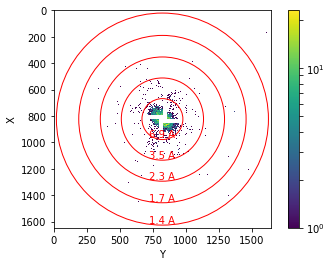

In [5]:
import sys
ROOT_DIR = ".."
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

import os
import time
import numpy as np
import random
import six
import itertools
import h5py as h5
from mpi4py import MPI # module required to use MPI
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pysingfel as ps
import pysingfel.gpu as pg
from pysingfel.util import asnumpy, xp

beam = ps.Beam(ROOT_DIR+'/input/beam/amo86615.beam')
beam._n_phot *= 1e2
print 'number of photons per shot:', beam._n_phot

det = ps.Epix10kDetector(geom=ROOT_DIR+'/input/lcls/xcsx35617/Epix10ka2M::CalibV1/XcsEndstation.0:Epix10ka2M.0/geometry/0-end.data',beam=beam)
# reset detector distance for desired resolution
# aim for 5A to 7A resolution
det.distance *= 0.25
print 'detector distance:', det.distance

particle = ps.Particle()
particle.read_pdb(ROOT_DIR+'/input/pdb/2CEX.pdb', ff='WK')

experiment = ps.SPIExperiment(det, beam, particle)
adu = experiment.generate_image_stack()

print adu[10][3][381]
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
img = experiment.det.assemble_image_stack(adu)
viz.imshow(img)
plt.show()

GAIN_MODES = ['FH','FM','FL','AHL-H','AML-M','AHL-L','AML-L']

temp check in relativeSmear array handler
temp check in absoluteSmear array handler
bauf stuff
107365.828295
[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.      

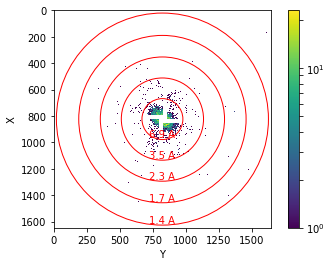

In [6]:
import psana
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from Detector.UtilsEpix10ka import find_gain_mode
from Detector.GlobalUtils import print_ndarr

experimentName = 'xcsx35617'
#runNumber = '89' ## runs 89-96: High Gain --> FH
runNumber = '107' ## runs 99-107: MEdium gain --> FM
#runNumber = '421' ## low-gain dark run --> FL
#runNumber = '488' ## runs 488-491: autoML
#runNumber = '483' ## runs 483-485: autoHL
detName = 'epix10ka2m'
ds = psana.DataSource('exp='+experimentName+':run='+runNumber+':idx')
run = ds.runs().next()
det = psana.Detector(detName)
times = run.times()

env = ds.env()
peds = None
mask = None
gain = None

panels = 16
rows = 352
cols = 384
det_autoranging = AutoRangingDetector(panels, rows, cols, "ePix10k", "fixedMedium")
if False:
    print "residual gains"
    print det_autoranging.residualGains
    print det_autoranging.residualGains.mean(), det_autoranging.residualGains.std()

I0width = 0.03
flatField = np.ones((panels, rows, cols))
for i in range(panels):
    for j in range(rows):
        for k in range(cols):
            flatField[i, j, k] = 24*np.random.random()
#flatField[i, j, k] = -= 0.1*(np.random.random()-0.5)

#bauf = BuildAutoRangeFrames(det_autoranging, I0width, 0, 150000, flatField)

Field = adu*4.6
bauf = BuildAutoRangeFrames(det_autoranging, I0width, 0, 150000, Field)

for enum, i in enumerate(times):
    if enum > 2: break
    
    bauf.makeFrame()
    if True:##False:
        print "bauf stuff"
        print bauf.I0
        print bauf.frame
        print bauf.gainBits
        calib = bauf.frame/4.6
        print calib.shape
        print 'calib', calib[10][3][381]
                
    evt = run.event(i)
    raw = det.raw(evt)
    if raw is None:
        continue
    if peds is None:
        peds = det.pedestals(evt)[1].astype(np.uint16)
        print_ndarr(peds, 'peds')
    if mask is None:
        mask = det.status_as_mask(evt)
        print_ndarr(mask, 'mask')
    if gain is None:
        gain = det.gain(evt)[1]
        print_ndarr(gain, 'gain')
    img = det.image(evt, calib)
    med = np.median(calib)
    spr = np.median(np.abs(calib-med))
    print 'median, spread:', med, spr
    viz.imshow(img)
    plt.show()
    break